Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. Внимание! выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.


Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.


Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.


Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.


Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.


Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.


Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.


Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.


Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

In [46]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [92]:
PATH = 'C:/Users/Kokorozaci/Downloads/assignment2_data/'
train = pd.read_csv(PATH + "assignment_2_train.csv")
test = pd.read_csv(PATH + "assignment_2_test.csv")
print("data.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

data.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
y_train = train["isFraud"]
y_test = test["isFraud"]
x_train = train.set_index('TransactionID')
x_train = train.drop("isFraud", axis=1)
x_test = test.set_index('TransactionID')
x_test = test.drop("isFraud", axis=1)
print("data.shape = {} rows, {} cols".format(*train.shape), "data.shape = {} rows, {} cols".format(*test.shape))

data.shape = 180000 rows, 394 cols data.shape = 100001 rows, 394 cols


In [94]:
class FeatureImputer:
    """Обработка категориальных фич"""
    
    def __init__(self):
        self.numerical_features_col=None
        self.categorical_features_col=None
        self.bin_features_col = None
        self.m = None
        self.m_P_emaildomain = None
        self.m_ProductCD = None
        self.m_card4 = None
        self.m_card6 = None
        
    def fit(self, X):
        self.numerical_features_col = X.select_dtypes(include=[np.number]).columns
        self.categorical_features_col = train.select_dtypes('object').columns
        self.m = {f: {} for f in self.categorical_features_col}
        self.bin_features_col = []
        for feature in self.categorical_features_col:
            if len(X[feature].value_counts()) == 2:
                self.bin_features_col.append(feature)
                continue
            self.m[feature] = {v:k for k, v in enumerate(train.groupby(feature).count().index)}
        self.m['bin'] = {'F': 0, 'T': 1}
    
    def transform(self, X): 
        for feature in self.categorical_features_col:
            if len(X[feature].value_counts()) != 2:
                X[feature] = X[feature].map(self.m[feature])  
        X[self.bin_features_col] = X[self.bin_features_col].apply(lambda x: x.map(self.m['bin']))

        return X

In [95]:
imputer = FeatureImputer()

imputer.fit(x_train)

x_test = imputer.transform(x_test)
x_train = imputer.transform(x_train)

Text(0.5, 1.0, 'TransactionDT')

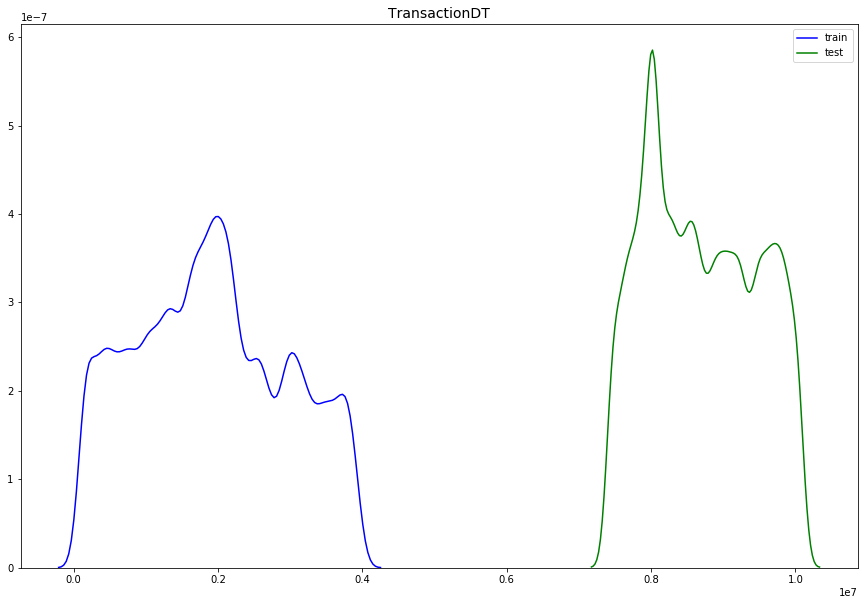

In [59]:
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

train_data, test_data = train['TransactionDT'].copy(), test['TransactionDT'].copy()
sns.kdeplot(train_data, ax=axes, color="blue", label="train")
sns.kdeplot(test_data, ax=axes, color="green", label="test")
axes.set_title('TransactionDT', fontsize=14)

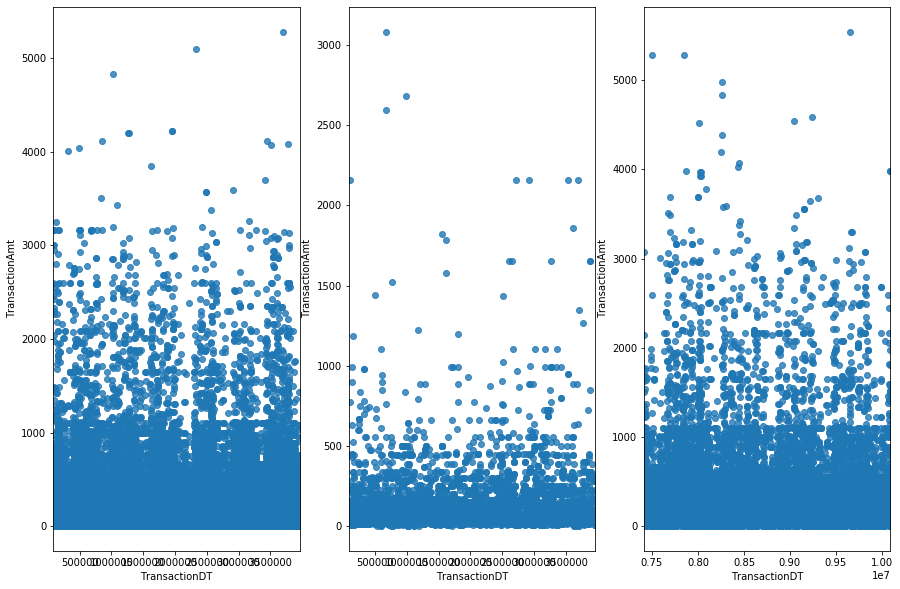

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=train.loc[train["isFraud"] == 0],
        ax=axes[0],
        scatter=True,
        fit_reg=True
    )

sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=train.loc[train["isFraud"] == 1],
        ax=axes[1],
        scatter=True,
        fit_reg=True
    )

sns.regplot(
        x='TransactionDT',
        y='TransactionAmt',
        data=test,
        ax=axes[2],
        scatter=True,
        fit_reg=True
    )

In [10]:
from scipy.stats import probplot

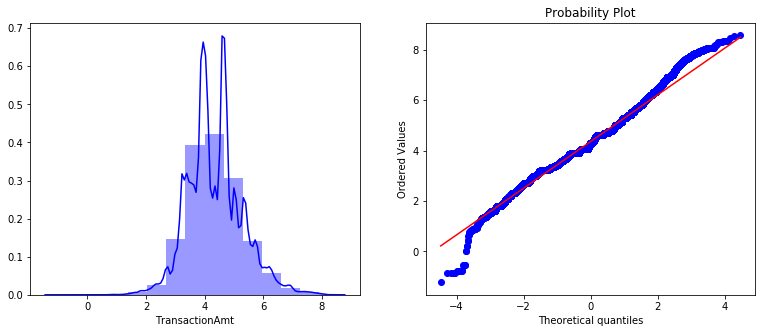

In [11]:
target = np.log(train['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, bins=15, color="blue")
plt.subplot(122)
probplot(target, plot=plt)
plt.show()

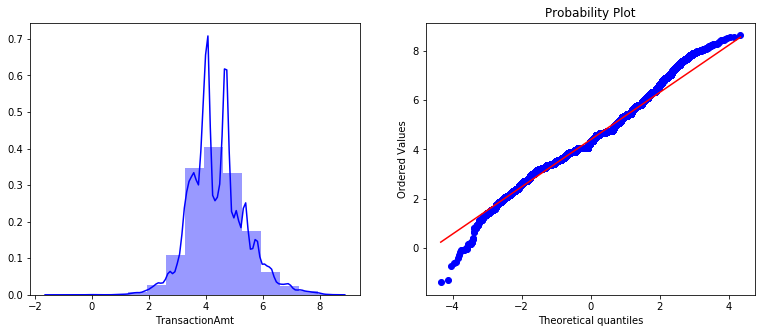

In [12]:
target = np.log(test['TransactionAmt'])
fig = plt.figure(figsize=(13, 5))
plt.subplot(121)
sns.distplot(target, bins=15, color="blue")
plt.subplot(122)
probplot(target, plot=plt)
plt.show()

## Hold-Out валидация (валидация на отложенной выборке)


In [52]:
# from sklearn.model_selection import TimeSeriesSplit
# cv = TimeSeriesSplit()
# cv.split?

In [81]:
def hold_out_val(X, y):
    x_train, x_test = X[:int(X.shape[0]*0.75)], X[int(X.shape[0]*0.75):]
    y_train, y_test = y[:int(y.shape[0]*0.75)], y[int(y.shape[0]*0.75):]
    
    params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
    }

    dtrain = xgb.DMatrix(
        data=x_train, label=y_train
    )
    dvalid = xgb.DMatrix(
        data=x_test, label=y_test
    )

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=10,
        maximize=True,
    )
    
    train_score = roc_auc_score(y_train, model.predict(dtrain))
    test_score = roc_auc_score(y_test, model.predict(dvalid))
    
    scores = create_bootstrap_metrics(y_test, model.predict(dvalid), roc_auc_score)

    print(calculate_confidence_interval(scores))
    
    return model, train_score, test_score

In [164]:
def hold_out_val_2(x_train, x_test, y_train, y_test):
    
    params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
    }

    dtrain = xgb.DMatrix(
        data=x_train, label=y_train
    )
    dvalid = xgb.DMatrix(
        data=x_test, label=y_test
    )

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=10000,
        early_stopping_rounds=50,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=10,
        maximize=True,
    )
    
    train_score = roc_auc_score(y_train, model.predict(dtrain))
    test_score = roc_auc_score(y_test, model.predict(dvalid))
    
    scores = create_bootstrap_metrics(y_test, model.predict(dvalid), roc_auc_score)

    print(calculate_confidence_interval(scores))
    
    return model, train_score, test_score

In [83]:
model, train_score, test_score = hold_out_val(x_train, y_train)
dliderbord = xgb.DMatrix(
    data=x_test)
lb_score = roc_auc_score(y_test, model.predict(dliderbord))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, Lb-score: {round(lb_score, 3)}")

[13:31:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.59781	valid-auc:0.61482
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.75016	valid-auc:0.74657
[20]	train-auc:0.85049	valid-auc:0.83531
[30]	train-auc:0.86490	valid-auc:0.84370
[40]	train-auc:0.88121	valid-auc:0.85347
[50]	train-auc:0.89080	valid-auc:0.86063
[60]	train-auc:0.89673	valid-auc:0.86829
[70]	train-auc:0.90139	valid-auc:0.87394
[80]	train-auc:0.90410	valid-auc:0.87692
[90]	train-auc:0.90733	valid-auc:0.87898
[100]	train-auc:0.90954	valid-auc:0.88077
[110]	train-auc:

In [73]:
x_trains = x_train[:int(x_train.shape[0]/3)], x_train[int(x_train.shape[0]/3):int(x_train.shape[0]/3)*2], x_train[int(x_train.shape[0]/3)*2:]
y_trains = y_train[:int(y_train.shape[0]/3)], y_train[int(y_train.shape[0]/3):int(y_train.shape[0]/3)*2], y_train[int(y_train.shape[0]/3)*2:]

In [75]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [82]:
for x, y in zip(x_trains, y_trains):
    print(x.shape)
    model, train_score, test_score = hold_out_val(x, y)
    print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, Lb-score: {round(lb_score, 3)}")
    np.random.seed(27)


(60000, 393)
[13:29:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.60143	valid-auc:0.62997
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.72649	valid-auc:0.76174
[20]	train-auc:0.83095	valid-auc:0.83427
[30]	train-auc:0.85043	valid-auc:0.85260
[40]	train-auc:0.87486	valid-auc:0.86637
[50]	train-auc:0.88566	valid-auc:0.87440
[60]	train-auc:0.89279	valid-auc:0.87846
[70]	train-auc:0.89880	valid-auc:0.88170
[80]	train-auc:0.90266	valid-auc:0.88412
[90]	train-auc:0.90538	valid-auc:0.88530
[100]	train-auc:0.90738	valid-auc:0.88604
[11

вся выборка

Train-score: 0.918, Test-score: 0.886, Lb-score: 0.868
(0.8756754931931142, 0.8959744513866584)

1/3 выборки

Train-score: 0.908, Test-score: 0.887, Lb-score: 0.868
(0.866801402730228, 0.9055374306948475)

Train-score: 0.907, Test-score: 0.877, Lb-score: 0.868
(0.8497179019875568, 0.901174466650485)

Train-score: 0.913, Test-score: 0.889, Lb-score: 0.868
(0.8726668717002917, 0.9048784118500227)

Text(0.5, 0, 'sampel number')

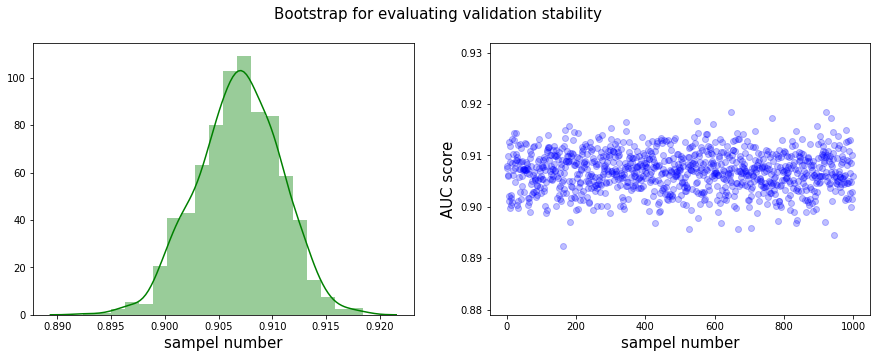

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("AUC score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)



__Adversarial validation__

In [124]:
x_adv = pd.concat([
    x_train, x_test], axis=0
)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(x_test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [125]:
x_adv = x_adv.drop(['TransactionID', 'TransactionDT'], axis=1)

In [144]:
model = xgb.XGBClassifier(n_estimators=10)
model.fit(x_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [145]:
y_pred_adv = model.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.8863


In [129]:
x_t = x_train.drop(['TransactionID', 'TransactionDT'], axis=1)

In [146]:
y_pred = model.predict_proba(x_t)
y_pred

array([[0.8295057 , 0.17049435],
       [0.7213311 , 0.27866888],
       [0.728493  , 0.27150702],
       ...,
       [0.6289675 , 0.37103248],
       [0.85890335, 0.14109665],
       [0.8987902 , 0.10120983]], dtype=float32)

In [154]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts()

(0.0, 0.1]     10931
(0.1, 0.2]    101682
(0.2, 0.3]     37414
(0.3, 0.4]     11606
(0.4, 0.5]      9268
(0.5, 0.6]      4925
(0.6, 0.7]      3990
(0.7, 0.8]        87
(0.8, 0.9]        29
(0.9, 1.0]        68
dtype: int64

In [148]:
x_valid, y_valid = x_train[y_pred[:, 1] >= 0.5], y_train[y_pred[:, 1] >= 0.5]
x_train_1, y_train_1 = x_train[y_pred[:, 1] < 0.5], y_train[y_pred[:, 1] < 0.5]

In [162]:
x_valid.shape

(9099, 393)

In [167]:
model, train_score, test_score = hold_out_val_2(x_train_1, x_valid, y_train_1, y_valid)

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, Lb-score: {round(lb_score, 3)}")

[23:17:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.65234	valid-auc:0.55072
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[10]	train-auc:0.79724	valid-auc:0.68271
[20]	train-auc:0.82590	valid-auc:0.71353
[30]	train-auc:0.86491	valid-auc:0.82580
[40]	train-auc:0.88014	valid-auc:0.83570
[50]	train-auc:0.88989	valid-auc:0.84117
[60]	train-auc:0.89672	valid-auc:0.84489
[70]	train-auc:0.90158	valid-auc:0.84696
[80]	train-auc:0.90468	valid-auc:0.85016
[90]	train-auc:0.90705	valid-auc:0.85261
[100]	train-auc:0.90960	valid-auc:0.85431
[110]	train-auc:

In [168]:
cv = cross_val_score(
    estimator=model,
    X=x_train_1,
    y=y_train_1,
    scoring="auc",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

TypeError: estimator should be an estimator implementing 'fit' method, <xgboost.core.Booster object at 0x00000165A9C18748> was passed